In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import baltic as bt
from itertools import combinations, product
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
titer_file = '../data/katzelnick2015/processed/normalized_titers.csv'
colors = pickle.load(open('./colors.p', 'rb'))
out_path = './png'

In [3]:
titers = pd.read_csv(titer_file, sep=',', index_col=0)
titers = titers.groupby(['virus', 'sera'])['autologous_log2titer'].agg('mean').reset_index()
titers = titers.pivot(index='virus', columns='sera', values='autologous_log2titer')

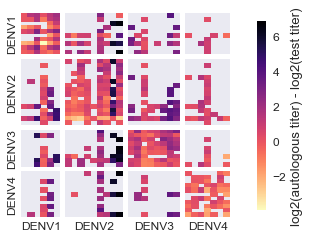

In [6]:
def split_serotypes(df):
    '''Return dictionary of {virus_rows: {sera_column: df}} for plotting heatmap small multiples'''
    columns = { s : [ i for i in df.columns.values if i.startswith('DENV%d'%s) ] for s in [1,2,3,4] }
    rows = { s : [i for i in df.index.values if i.startswith('DENV%d'%s) ] for s in [1,2,3,4] }
    split_serotypes = {1: {}, 2: {}, 3: {}, 4: {}} # { serotype_1_viruses: {vs_serotype_1_sera: partial_df, vs_2: ...}, ...}

    for serum_serotype in [1,2,3,4]:
        for virus_serotype in [1,2,3,4]:
            partial_design_matrix = df.loc[rows[virus_serotype], columns[serum_serotype]]
            split_serotypes[serum_serotype][virus_serotype] = partial_design_matrix
    return split_serotypes

def plot_small_multiples(titer_df, cmap=colors['cmap']):
    data = split_serotypes(titer_df)
    sns.set(style='dark', font_scale=1.2)

    ## Set subplot size ratios
    width_ratios = [ len(data[i][1].columns.values) for i in [1,2,3,4] ]
    max_w = max(width_ratios)
    width_ratios = [ i / float(max_w) for i in width_ratios ]
    height_ratios = [ len(data[1][i].index.values) for i in [1,2,3,4]]
    max_h = max(height_ratios)
    height_ratios = [ i / float(max_h) for i in height_ratios ]    

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(7.5/2,7.5/2), facecolor='white',
                             gridspec_kw={'wspace': 0.1, 'hspace':0.1,
                            'width_ratios': width_ratios, 'height_ratios': height_ratios})

    ## Set colors
    cmap = plt.get_cmap(cmap)

    all_values = []
    for (virus, serum) in product([1,2,3,4], repeat=2):
        all_values += [i for i in data[virus][serum].values.flatten() if not np.isnan(i) ]
    vmin_val = float(min(all_values)) # Anchor color map for entire figure at global min/max values
    vmax_val = float(max(all_values))
    cbar_axis = fig.add_axes([1.0, 0.15, .03, 0.7])

    for virus, row in enumerate(axes, start=1):
        for serum, axis in enumerate(row, start=1):
            if virus == 1 and serum == 4:
                cbar_bool = True
            else:
                cbar_bool = False

            plot = sns.heatmap(data[serum][virus], ax=axis, 
                        vmin=vmin_val, vmax=vmax_val, cmap=cmap,
                       xticklabels = False, yticklabels=False, cbar = cbar_bool, cbar_ax=cbar_axis,
                              cbar_kws={'label': 'log2(autologous titer) - log2(test titer)'})
            axis.set_xlabel('')
            axis.set_ylabel('')
            if virus == 4:
                plot.set_xlabel('DENV%d'%serum, fontsize=12)
            if serum == 1:
                plot.set_ylabel('DENV%d'%virus, fontsize=12)

plot_small_multiples(titers)
plt.savefig('./png/titer_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()